# GP v/s Deep GP on 2d data

In this notebook, we will be comparing three models (all RBF kernel) on a simulated 2d data:
    
- GP
- GP with ARD
- Deep GP 

In [1]:
import GPy

In [2]:
import numpy as np
import pyDOE2
from sklearn.metrics import mean_squared_error
# Plotting tools
from matplotlib import pyplot as plt
from matplotlib import rc

rc('font', size=16)
rc('text', usetex=True)

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

We generate pseudo data using the following function,

$$
y = \frac{(x_1+2)(2-x_2^2)}{3}
$$

In [3]:
np.random.seed(0)
X = pyDOE2.doe_lhs.lhs(2, 9, random_state=0)
func = lambda x: ((x[:, 0]+2)*(2-x[:, 1])**2)/3
y = func(X)

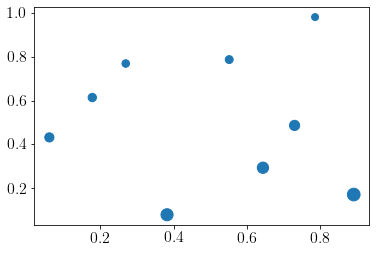

In [4]:
plt.scatter(X[:,0], X[:, 1],s=y*50);

## GP without ARD

In [5]:
k_2d = GPy.kern.RBF(input_dim=2, lengthscale=1)

In [6]:
m = GPy.models.GPRegression(X, y.reshape(-1, 1), k_2d)
m.optimize();

In [7]:
m

GP_regression.,value,constraints,priors
rbf.variance,72.28075242747792,+ve,
rbf.lengthscale,3.382677032484262,+ve,
Gaussian_noise.variance,9.922601887760885e-06,+ve,


In [8]:
x_1 = np.linspace(0, 1, 40)
x_2 = np.linspace(0, 1, 40)

X1, X2 = np.meshgrid(x_1, x_2)
X_new = np.array([(x1, x2) for x1, x2 in zip(X1.ravel(), X2.ravel())])
Y_true = func(X_new)

In [9]:
Y_pred, Y_cov = m.predict(X_new)
Y_95 = 2*np.sqrt(Y_cov)

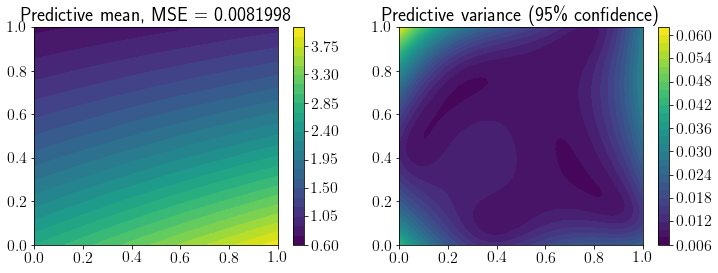

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
mp = ax[0].contourf(X1, X2, Y_pred.reshape(*X1.shape), levels=30)
fig.colorbar(mp, ax=ax[0])
ax[0].set_title(f'Predictive mean, MSE = {mean_squared_error(Y_true, Y_pred, squared=False).round(7)}');

mp = ax[1].contourf(X1, X2, Y_95.reshape(*X1.shape), levels=30)
ax[1].set_title(f'Predictive variance (95\% confidence)')
fig.colorbar(mp, ax=ax[1]);

## GP with ARD

In [11]:
k_2d_ARD = GPy.kern.RBF(input_dim=2, lengthscale=1, ARD=True)

In [12]:
m = GPy.models.GPRegression(X, y.reshape(-1, 1), k_2d_ARD)
m.optimize();

In [13]:
m

GP_regression.,value,constraints,priors
rbf.variance,40.53729208947549,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,4.3169473160951275e-29,+ve,


In [14]:
Y_pred, Y_cov = m.predict(X_new)
Y_95 = 2*np.sqrt(Y_cov)

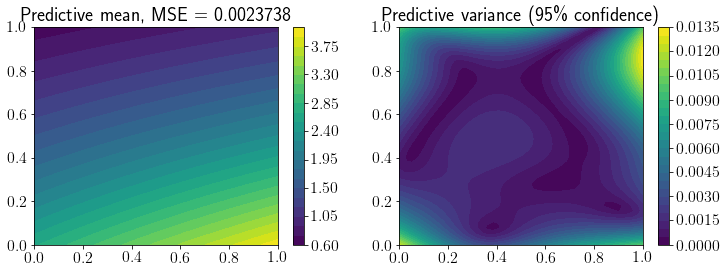

In [15]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
mp = ax[0].contourf(X1, X2, Y_pred.reshape(*X1.shape), levels=30)
fig.colorbar(mp, ax=ax[0])
ax[0].set_title(f'Predictive mean, MSE = {mean_squared_error(Y_true, Y_pred, squared=False).round(7)}');

mp = ax[1].contourf(X1, X2, Y_95.reshape(*X1.shape), levels=30)
ax[1].set_title(f'Predictive variance (95\% confidence)')
fig.colorbar(mp, ax=ax[1]);

In [16]:
m.parameters[0].lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],5.80242511,+ve,
[1],1.80657554,+ve,


We see that lengthscale for $x_1$ is higher because of linear relationship with the output and lengthscale for $x_2$ is higher due to quadratic relationship with the output.

## Deep GP

In [17]:
import deepgp
layers = [1, 1,  X.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i, ARD=True)]
    
m = deepgp.models.DeepGP(layers,Y=y.reshape(-1, 1), X=X, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=4, back_constraint=False)

In [18]:
m.optimize()

In [19]:
m

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(4, 1)",,
obslayer.rbf.variance,23.808937388338997,+ve,
obslayer.rbf.lengthscale,4.451925378737478,+ve,
obslayer.Gaussian_noise.variance,0.0020011072507906376,+ve,
obslayer.Kuu_var,"(4,)",+ve,
obslayer.latent space.mean,"(9, 1)",,
obslayer.latent space.variance,"(9, 1)",+ve,
layer_1.inducing inputs,"(4, 2)",,
layer_1.rbf.variance,30.67508979761088,+ve,
layer_1.rbf.lengthscale,"(2,)",+ve,


In [20]:
Y_pred, Y_cov = m.predict(X_new)
Y_95 = 2*np.sqrt(Y_cov)

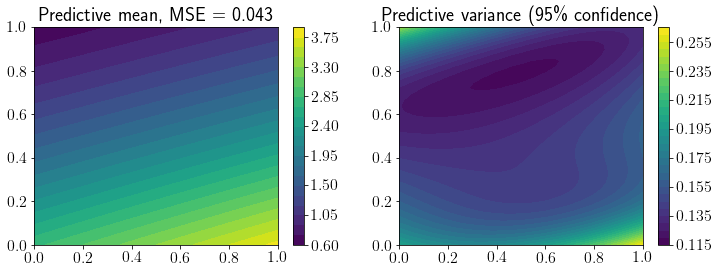

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
mp = ax[0].contourf(X1, X2, Y_pred.reshape(*X1.shape), levels=30)
fig.colorbar(mp, ax=ax[0])
ax[0].set_title(f'Predictive mean, MSE = {mean_squared_error(Y_true, Y_pred, squared=False).round(3)}');

mp = ax[1].contourf(X1, X2, Y_95.reshape(*X1.shape), levels=30)
ax[1].set_title(f'Predictive variance (95\% confidence)')
fig.colorbar(mp, ax=ax[1]);

Not working
Pinball_plot : https://github.com/lawrennd/talks/blob/gh-pages/deepgp_tutorial.py